In [97]:
import pandas as pd
import datetime as dt
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic


In [2]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

### Hint animation android

In [7]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  app_info.version,
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Ten seconds"
    END AS experimentVariant,  
    MAX(if(eventParam.key = "picture_id", eventParam.value.string_value, NULL)) AS picture_id,
    MAX(if(eventParam1.key = "shapes_count", eventParam1.value.string_value, NULL)) as shapes_count
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam,
    UNNEST(event_params) AS  eventParam1
where userProperty.key = "firebase_exp_15" 
and app_info.version in  ('2.1', '2.1.1', '2.1.2') 
and event_date between '2021-05-01' and '2021-05-31'
and event_name in ('core_unexpected_exit', "picture_start", "core_picture_start", "picture_back", "core_back_button_tap",
"picture_finish", "core_picture_finish") 
and lower(platform) = 'android'
group by event_date, event_timestamp, event_name, user_id,  app_info.version, userProperty.value.string_value 
'''
# hint_animation = client.query(sql, project=project_id).to_dataframe()

In [385]:
android_picture_started = hint_animation[hint_animation.event_name=='core_picture_start'][['user_id', 'experimentVariant', 'picture_id']]
android_picture_finished = hint_animation[hint_animation.event_name=='core_picture_finish'][['user_id', 'experimentVariant', 'picture_id']]

In [386]:
android_picture_max_finished = hint_animation[hint_animation.event_name.isin(["core_back_button_tap", 'core_unexpected_exit'])].groupby(
['user_id', 'experimentVariant', 'picture_id']).shapes_count.max().reset_index()

In [387]:
android_picture_finished['finished'] = 1
android_picture_started = android_picture_started.merge(android_picture_finished, how='left', 
                                                        on=["user_id", "experimentVariant", "picture_id"])
android_picture_started = android_picture_started.merge(android_picture_max_finished, how='left', 
                                                        on=["user_id", "experimentVariant", "picture_id"])


In [388]:
client = bigquery.Client.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'
sql = '''
SELECT distinct picture_id, shapes_count as total_shapes
FROM `goingtoclouds.feed.all_feed`
'''
picture_shapes = client.query(sql, project=project_id).to_dataframe()

In [389]:
android_picture_started = android_picture_started.merge(picture_shapes, on='picture_id', how='left')
android_picture_started.fillna(0, inplace=True)
android_picture_started.shapes_count = android_picture_started.shapes_count.astype(float)
android_picture_started['finish_coef'] = np.where(android_picture_started.finished==1, 1, 
                                                 np.where(android_picture_started.shapes_count==0, 0,
                                                          android_picture_started.shapes_count/android_picture_started.total_shapes))



In [390]:
tb = android_picture_started.groupby('experimentVariant').agg({'user_id':'count', 'finished':'sum'}).reset_index()
tb

experimentVariant  user_id  finished
0          Baseline    78083   64675.0
1       Ten seconds    77637   63875.0

In [391]:
tb['share'] = tb.finished/tb.user_id
tb

experimentVariant  user_id  finished     share
0          Baseline    78083   64675.0  0.828285
1       Ten seconds    77637   63875.0  0.822739

In [393]:
android_picture_started.groupby('experimentVariant').finish_coef.describe()

count      mean       std  min  25%  50%  75%       max
experimentVariant                                                           
Baseline           78083.0  0.875286  0.308634  0.0  1.0  1.0  1.0  1.000000
Ten seconds        77637.0  0.875130  0.307346  0.0  1.0  1.0  1.0  1.007722

In [70]:
android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finished

user_id experimentVariant                picture_id  finished  \
0       905214       Ten seconds  609519270cc80900181a6bf8       1.0   
2       121090       Ten seconds  609519270cc80900181a6bf8       1.0   
4       894727       Ten seconds  5fa1075800f5f10018ff9118       0.0   
6       810292       Ten seconds  6054baaecb605d0018e8d349       1.0   
10      902960       Ten seconds  60744677d18c23001867b399       1.0   
...        ...               ...                       ...       ...   
155707  335504       Ten seconds  609cccb10cc80900181a6c12       1.0   
155708  842082       Ten seconds  5f7f0dd772654d001885c56b       1.0   
155711  472935       Ten seconds  5fc7bc5301813a0018df0d15       0.0   
155715  660454       Ten seconds  606acc06d18c23001867b31c       1.0   
155716  803790       Ten seconds  609394270cc80900181a6bca       0.0   

        shapes_count  total_shapes  finish_coef  
0                0.0         596.0     1.000000  
2              596.0         596.0     1.000000  
4                0.0         757.0     0.000000  
6              408.0         408.0     1.000000  
10              65.0         613.0     1.000000  
...              ...           ...          ...  
155707         767.0         767.0     1.000000  
155708          81.0         479.0     1.000000  
155711           0.0         402.0     0.000000  
155715         489.0         489.0     1.000000  
155716           4.0         797.0     0.005019  

[77637 rows x 7 columns]

In [459]:
conf_interval_android_a = proportion_confint(sum(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finished), 
                                            len(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finished),
                                            method = 'wilson')
conf_interval_android_b = proportion_confint(sum(android_picture_started[android_picture_started.experimentVariant=='Baseline'].finished), 
                                            len(android_picture_started[android_picture_started.experimentVariant=='Baseline'].finished),
                                            method = 'wilson')

print('interval for Ten seconds [%f, %f]' % conf_interval_android_a)
print('interval for Baseline [%f, %f]' % conf_interval_android_b)

interval for Ten seconds [0.820037, 0.825410]
interval for Baseline [0.825624, 0.830915]


In [395]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

print("confidence interval: [%f, %f]" % 
      proportions_confint_diff_ind(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finished, 
                                   android_picture_started[android_picture_started.experimentVariant=='Baseline'].finished))

confidence interval: [-0.009316, -0.001776]


In [396]:
android_picture_started.groupby('experimentVariant').finish_coef.describe()

count      mean       std  min  25%  50%  75%       max
experimentVariant                                                           
Baseline           78083.0  0.875286  0.308634  0.0  1.0  1.0  1.0  1.000000
Ten seconds        77637.0  0.875130  0.307346  0.0  1.0  1.0  1.0  1.007722

In [397]:
seconds_10 = android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finish_coef.std(ddof=1)/np.sqrt(len(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finish_coef))
seconds_10_mean = android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finish_coef.mean()

seconds_15 = android_picture_started[android_picture_started.experimentVariant=='Baseline'].finish_coef.std(ddof=1)/np.sqrt(len(android_picture_started[android_picture_started.experimentVariant=='Baseline'].finish_coef))
seconds_15_mean = android_picture_started[android_picture_started.experimentVariant=='Baseline'].finish_coef.mean()

In [398]:
print("95%% confidence interval", _tconfint_generic(seconds_10_mean, seconds_10,
                                                    len(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].finish_coef) - 1,
                                                                       0.05, 'two-sided'))
print("95%% confidence interval", _tconfint_generic(seconds_15_mean, seconds_15,
                                                    len(android_picture_started[android_picture_started.experimentVariant=='Baseline']) - 1,
                                                                         0.05, 'two-sided'))

95%% confidence interval (0.8729683860905129, 0.8772923068625671)
95%% confidence interval (0.8731209572228563, 0.8774505829152407)


In [137]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  app_info.version,
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Ten seconds"
    END AS experimentVariant,  
    MAX(if(eventParam.key = "picture_id", eventParam.value.string_value, NULL)) AS picture_id,
    MAX(if(eventParam1.key = "finding_shape_time", eventParam1.value.string_value, NULL)) as finding_shape_time
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam,
    UNNEST(event_params) AS  eventParam1
where userProperty.key = "firebase_exp_15" 
and app_info.version in  ('2.1', '2.1.1', '2.1.2') 
and event_date between '2021-05-01' and '2021-05-31'
and event_name = 'core_hint_zone' 
and lower(platform) = 'android'
group by event_date, event_timestamp, event_name, user_id,  app_info.version, userProperty.value.string_value 
'''
# android_shape_time = client.query(sql, project=project_id).to_dataframe()

In [399]:
android_shape_time_conv = android_shape_time[['picture_id', 'user_id', 'experimentVariant']].drop_duplicates()
android_shape_time_conv['hint_conv'] = 1

In [400]:
android_picture_started = android_picture_started.merge(android_shape_time_conv, how='left', on=['picture_id', 'user_id', 'experimentVariant'])
android_picture_started.fillna(0, inplace=True)  

In [460]:
android_picture_started

user_id experimentVariant                picture_id  finished  \
0       905214       Ten seconds  609519270cc80900181a6bf8       1.0   
1       899350          Baseline  605ca058d18c23001867b2a0       1.0   
2       121090       Ten seconds  609519270cc80900181a6bf8       1.0   
3       913304          Baseline  60743fbdd18c23001867b390       0.0   
4       894727       Ten seconds  5fa1075800f5f10018ff9118       0.0   
...        ...               ...                       ...       ...   
155715  660454       Ten seconds  606acc06d18c23001867b31c       1.0   
155716  803790       Ten seconds  609394270cc80900181a6bca       0.0   
155717  777745          Baseline  60101ce389729b0018eeb18e       1.0   
155718  851870          Baseline  6087d8b543121d00189fae9b       0.0   
155719  892694          Baseline  609cd77b0cc80900181a6c17       1.0   

        shapes_count  total_shapes  finish_coef  hint_conv  
0                0.0         596.0     1.000000        0.0  
1              677.0         677.0     1.000000        0.0  
2              596.0         596.0     1.000000        1.0  
3                0.0         393.0     0.000000        0.0  
4                0.0         757.0     0.000000        0.0  
...              ...           ...          ...        ...  
155715         489.0         489.0     1.000000        0.0  
155716           4.0         797.0     0.005019        0.0  
155717         620.0         620.0     1.000000        1.0  
155718          49.0         236.0     0.207627        0.0  
155719           0.0         699.0     1.000000        0.0  

[155720 rows x 8 columns]

### Конверсия в хинт

In [401]:
tb = android_picture_started.groupby('experimentVariant').agg({'user_id':'count', 'hint_conv':'sum'}).reset_index()
tb['share'] = tb.hint_conv/tb.user_id
tb

experimentVariant  user_id  hint_conv     share
0          Baseline    78083    15033.0  0.192526
1       Ten seconds    77637    13845.0  0.178330

In [402]:
conf_interval_android_a = proportion_confint(sum(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].hint_conv), 
                                            len(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].hint_conv),
                                            method = 'wilson')
conf_interval_android_b = proportion_confint(sum(android_picture_started[android_picture_started.experimentVariant=='Baseline'].hint_conv), 
                                            len(android_picture_started[android_picture_started.experimentVariant=='Baseline'].hint_conv),
                                            method = 'wilson')

print('interval for Ten seconds [%f, %f]' % conf_interval_android_a)
print('interval for Baseline [%f, %f]' % conf_interval_android_b)

interval for Ten seconds [0.175653, 0.181039]
interval for Baseline [0.189775, 0.195307]


In [2]:
# android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].hint_conv

In [403]:
print("confidence interval: [%f, %f]" % 
      proportions_confint_diff_ind(android_picture_started[android_picture_started.experimentVariant=='Ten seconds'].hint_conv, 
                                   android_picture_started[android_picture_started.experimentVariant=='Baseline'].hint_conv))

confidence interval: [-0.018056, -0.010336]


In [167]:
android_shape_time.finding_shape_time = android_shape_time.finding_shape_time.astype(int)
android_shape_time['finding_shape_time_sec'] = android_shape_time.finding_shape_time/1000

android_shape_time.groupby('experimentVariant').finding_shape_time_sec.median()

experimentVariant
Baseline       13.3320
Ten seconds    13.7445
Name: finding_shape_time_sec, dtype: float64

In [168]:
from scipy.stats import median_test

stat, p, med, tbl = median_test(android_shape_time[android_shape_time.experimentVariant=='Ten seconds'].finding_shape_time_sec, 
                                android_shape_time[android_shape_time.experimentVariant=='Baseline'].finding_shape_time_sec)

In [169]:
print(stat, p, med, tbl)

9.935769077392502 0.0016209769510850613 13.524 [[18117 19802]
 [17685 20239]]


## Hint animation IOS

In [104]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  app_info.version,
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Ten seconds"
    END AS experimentVariant,  
    MAX(if(eventParam.key = "picture_id", eventParam.value.string_value, NULL)) AS picture_id,
    MAX(if(eventParam1.key = "shapes_count", eventParam1.value.string_value, NULL)) as shapes_count
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam,
    UNNEST(event_params) AS  eventParam1
where userProperty.key = "firebase_exp_14" 
and event_date between '2021-05-01' and '2021-05-31'
and event_name in ( "picture_start", "core_picture_start", "picture_back", "core_back_button_tap",
"picture_finish", "core_picture_finish") 
and lower(platform) = 'ios'
group by event_date, event_timestamp, event_name, user_id,  app_info.version, userProperty.value.string_value 
'''
# hint_animation_ios = client.query(sql, project=project_id).to_dataframe()

In [410]:
hint_animation_ios.shapes_count = hint_animation_ios.shapes_count.astype(float)

ios_picture_started = hint_animation_ios[hint_animation_ios.event_name=='core_picture_start'][['user_id', 'experimentVariant', 'picture_id']]
ios_picture_finished = hint_animation_ios[hint_animation_ios.event_name=='core_picture_finish'][['user_id', 'experimentVariant', 'picture_id']]
ios_picture_max_finished = hint_animation_ios[hint_animation_ios.event_name.isin(["core_back_button_tap"])].groupby(
    ['user_id', 'experimentVariant', 'picture_id']).shapes_count.max().reset_index()
ios_picture_finished['finished'] = 1

In [411]:
ios_picture_started = ios_picture_started.merge(ios_picture_finished, how='left', on=["user_id", "experimentVariant", "picture_id"])
ios_picture_started = ios_picture_started.merge(ios_picture_max_finished, how='left', on=["user_id", "experimentVariant", "picture_id"])

ios_picture_started = ios_picture_started.merge(picture_shapes, on='picture_id', how='left')
ios_picture_started.fillna(0, inplace=True)
# ios_picture_started.shapes_count = ios_picture_started.shapes_count.astype(float)
ios_picture_started['finish_coef'] = np.where(ios_picture_started.finished==1, 1, 
                                                 np.where(ios_picture_started.shapes_count==0, 0,
                                                          ios_picture_started.shapes_count/ios_picture_started.total_shapes))



In [412]:
tb = ios_picture_started.groupby('experimentVariant').agg({'user_id':'count', 'finished':'sum'}).reset_index()
tb['share'] = tb.finished/tb.user_id
tb

experimentVariant  user_id  finished     share
0          Baseline   486543  423925.0  0.871300
1       Ten seconds   498451  431515.0  0.865712

In [413]:
ios_picture_started.groupby('experimentVariant').finish_coef.describe()

count      mean       std  min  25%  50%  75%        max
experimentVariant                                                             
Baseline           486543.0  0.957102  0.732128  0.0  1.0  1.0  1.0  57.756667
Ten seconds        498451.0  0.956056  0.799554  0.0  1.0  1.0  1.0  91.238739

In [414]:
conf_interval_ios_a = proportion_confint(sum(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].finished), 
                                            len(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].finished),
                                            method = 'wilson')
conf_interval_ios_b = proportion_confint(sum(ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].finished), 
                                            len(ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].finished),
                                            method = 'wilson')

print('interval for Ten seconds [%f, %f]' % conf_interval_ios_a)
print('interval for Baseline [%f, %f]' % conf_interval_ios_b)

interval for Ten seconds [0.864766, 0.866653]
interval for Baseline [0.870352, 0.872242]


In [415]:
print("confidence interval: [%f, %f]" % 
      proportions_confint_diff_ind(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].finished, 
                                   ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].finished))

confidence interval: [-0.006923, -0.004254]


In [170]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Ten seconds"
    END AS experimentVariant, 
    MAX(if(eventParam.key = "picture_id", eventParam.value.string_value, NULL)) AS picture_id,
    MAX(if(eventParam1.key = "finding_shape_time", eventParam1.value.string_value, NULL)) as finding_shape_time
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam,
    UNNEST(event_params) AS  eventParam1
where userProperty.key = "firebase_exp_14" 
and event_date between '2021-05-01' and '2021-05-31'
and event_name = "core_hint_zone"
and lower(platform) = 'ios'
group by event_date, event_timestamp, event_name, user_id, userProperty.value.string_value 
'''
# ios_shape_time = client.query(sql, project=project_id).to_dataframe()

In [416]:
ios_shape_time_conv = ios_shape_time[['picture_id', 'user_id', 'experimentVariant']].drop_duplicates()
ios_shape_time_conv['hint_conv'] = 1

ios_picture_started = ios_picture_started.merge(ios_shape_time_conv, how='left', on=['picture_id', 'user_id', 'experimentVariant'])
ios_picture_started.fillna(0, inplace=True)

In [417]:
tb = ios_picture_started.groupby('experimentVariant').agg({'user_id':'count', 'hint_conv':'sum'}).reset_index()
tb['share'] = tb.hint_conv/tb.user_id
tb

experimentVariant  user_id  hint_conv     share
0          Baseline   486543    76218.0  0.156652
1       Ten seconds   498451    77392.0  0.155265

In [418]:
conf_interval_android_a = proportion_confint(sum(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].hint_conv), 
                                            len(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].hint_conv),
                                            method = 'wilson')
conf_interval_android_b = proportion_confint(sum(ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].hint_conv), 
                                            len(ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].hint_conv),
                                            method = 'wilson')

print('interval for Ten seconds [%f, %f]' % conf_interval_android_a)
print('interval for Baseline [%f, %f]' % conf_interval_android_b)

interval for Ten seconds [0.154265, 0.156270]
interval for Baseline [0.155630, 0.157680]


In [419]:
print("confidence interval: [%f, %f]" % 
      proportions_confint_diff_ind(ios_picture_started[ios_picture_started.experimentVariant=='Ten seconds'].hint_conv, 
                                   ios_picture_started[ios_picture_started.experimentVariant=='Baseline'].hint_conv))

confidence interval: [-0.002820, 0.000046]


In [420]:
ios_shape_time.finding_shape_time = ios_shape_time.finding_shape_time.astype(int)
ios_shape_time['finding_shape_time_sec'] = ios_shape_time.finding_shape_time/1000

ios_shape_time.groupby('experimentVariant').finding_shape_time_sec.median()

experimentVariant
Baseline       15.299
Ten seconds    15.917
Name: finding_shape_time_sec, dtype: float64

In [421]:
stat, p, med, tbl = median_test(ios_shape_time[ios_shape_time.experimentVariant=='Ten seconds'].finding_shape_time_sec, 
                                ios_shape_time[ios_shape_time.experimentVariant=='Baseline'].finding_shape_time_sec)

In [422]:
print(stat, p, med, tbl)

62.977925618029076 2.090362237795385e-15 15.624 [[81711 78847]
 [79463 81098]]


In [423]:
round(p, 6)

0.0

### autoSwitchColor android


In [180]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp,  user_id,  
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "No auto switch"
    END AS experimentVariant, 
    max(if(userProperty1.key = "auto_switch", userProperty1.value.string_value, NULL)) AS auto_switch
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(user_properties) AS userProperty1,
    UNNEST(event_params) AS  eventParam
where userProperty.key = "firebase_exp_16" and userProperty1.key = "auto_switch"
and event_date between '2021-03-11' and '2021-03-13'
and event_name = 'launch'
and lower(platform) = 'android'
group by event_date, event_timestamp, user_id,  userProperty.value.string_value
'''

auto_switch = client.query(sql, project=project_id).to_dataframe()

In [184]:
auto_switch.groupby(['experimentVariant', 'auto_switch']).event_timestamp.count()

experimentVariant  auto_switch
Baseline           False           147
                   True           6566
No auto switch     False           171
                   True           6516
Name: event_timestamp, dtype: int64

In [185]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp,  user_id,  
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "No auto switch"
    END AS experimentVariant, 
    max(if(userProperty1.key = "auto_switch", userProperty1.value.string_value, NULL)) AS auto_switch
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(user_properties) AS userProperty1,
    UNNEST(event_params) AS  eventParam
where userProperty.key = "firebase_exp_16" and userProperty1.key = "auto_switch"
and event_date between '2021-05-01' and '2021-05-03'
and event_name = 'launch'
and lower(platform) = 'android'
group by event_date, event_timestamp, user_id,  userProperty.value.string_value
'''

auto_switch_5 = client.query(sql, project=project_id).to_dataframe()

In [186]:
auto_switch_5.groupby(['experimentVariant', 'auto_switch']).event_timestamp.count()

experimentVariant  auto_switch
Baseline           False            370
                   True           15473
No auto switch     False            372
                   True           15602
Name: event_timestamp, dtype: int64

In [188]:
sql = '''
SELECT event_date, timestamp_micros(event_timestamp) as event_timestamp,  user_id,  
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "No auto switch"
    END AS experimentVariant, 
    max(if(userProperty1.key = "auto_switch", userProperty1.value.string_value, NULL)) AS auto_switch
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(user_properties) AS userProperty1,
    UNNEST(event_params) AS  eventParam
where userProperty.key = "firebase_exp_16"
and event_date between '2021-04-01' and '2021-04-03'
and event_name = 'launch'
and lower(platform) = 'android'
group by event_date, event_timestamp, user_id,  userProperty.value.string_value
'''

auto_switch_4 = client.query(sql, project=project_id).to_dataframe()

In [189]:
auto_switch_4.groupby(['experimentVariant', 'auto_switch']).event_timestamp.count()

experimentVariant  auto_switch
Baseline           False            379
                   True           15952
No auto switch     False            443
                   True           16094
Name: event_timestamp, dtype: int64

## undo_android

In [190]:
sql = '''
SELECT distinct event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  app_info.version,
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Ten seconds"
    END AS experimentVariant
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam
where userProperty.key = "firebase_exp_13" 
and event_date between '2021-03-05' and '2021-03-29'
and lower(platform) = 'android'
group by event_date, event_timestamp, event_name, user_id,  app_info.version, userProperty.value.string_value 
'''
# undo_android = client.query(sql, project=project_id).to_dataframe()

In [194]:
undo_android[undo_android.event_name.str.contains("undo")].groupby(['experimentVariant', 'event_name']).event_timestamp.count()

experimentVariant  event_name            
Baseline           core_floating_undo_tap     8069
                   core_undo_tap             19084
Ten seconds        core_floating_undo_tap        3
                   core_undo_tap                31
Name: event_timestamp, dtype: int64

In [256]:
returned_users = undo_android[~undo_android.user_id.isna()][['event_date', 'user_id', 'experimentVariant']].drop_duplicates()
returned_users.user_id = returned_users.user_id.astype(float)

In [257]:
tb = returned_users.groupby('user_id').experimentVariant.nunique().reset_index()
tb[tb.experimentVariant>1].user_id.tolist()

returned_users = returned_users[~returned_users.isin(tb[tb.experimentVariant>1].user_id.tolist())]

In [198]:
client = bigquery.Client.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
SELECT distinct customer_user_id , install_date
FROM `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch` 
WHERE event_date between "2021-03-01" and "2021-03-31"
and platform = 'android'
'''
undo_android_install = client.query(sql, project=project_id).to_dataframe()
undo_android_install = undo_android_install[~undo_android_install.customer_user_id.isna()]

In [258]:
returned_users = returned_users.merge(undo_android_install, how='left', left_on='user_id', right_on='customer_user_id')
returned_users['cohort_day'] = (returned_users.event_date - returned_users.install_date).dt.days
returned_users = returned_users[returned_users.cohort_day>=0]

In [269]:
sql = '''
SELECT distinct event_date, customer_user_id as user_id, install_date, 
    date_diff(event_date, install_date, day) as cohort_day
FROM `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch` 
WHERE event_date between "2021-03-01" and "2021-04-30"
and platform = 'android' 
and date_diff(event_date, install_date, day)>=0
'''
launch_android = client.query(sql, project=project_id).to_dataframe()
launch_android = launch_android[launch_android.user_id.isin(returned_users.user_id.unique().tolist())]
launch_android = launch_android[["user_id", 'install_date', "event_date", "cohort_day"]]

In [270]:
returned_users_unique = returned_users[["user_id", "experimentVariant"]].drop_duplicates()

launch_android = launch_android.merge(returned_users_unique, how='left', on='user_id')

In [284]:
# leave installs after ab test start
launch_android = launch_android[(launch_android.install_date >= dt.date(2021,3,5)) & 
                               (launch_android.install_date<=dt.date(2021,3,29))]
launch_android_retention = launch_android[launch_android.cohort_day.isin([0,7,14,30])]
launch_android_retention

In [300]:
ret_android_agg = launch_android_retention.groupby(['experimentVariant', 'cohort_day']).user_id.nunique().reset_index()
ret_android_agg = pd.pivot_table(ret_android_agg, index='experimentVariant', columns='cohort_day', values='user_id').reset_index()

In [305]:
ret_android_agg['days_7'] = ret_android_agg[7]/ret_android_agg[0]
ret_android_agg['days_14'] = ret_android_agg[14]/ret_android_agg[0]
ret_android_agg['days_30'] = ret_android_agg[30]/ret_android_agg[0]

In [306]:
ret_android_agg

cohort_day experimentVariant     0     7   14   30    days_7   days_14  \
0                   Baseline  9754  1137  776  478  0.116568  0.079557   
1                Ten seconds  9626  1097  765  478  0.113962  0.079472   

cohort_day   days_30  
0           0.049006  
1           0.049657

In [440]:
day_0_base = launch_android_retention[(launch_android_retention.experimentVariant=='Baseline') & 
                                      (launch_android_retention.cohort_day==0)][['user_id']].drop_duplicates()
day_0_base['appeared'] = 0

day_0_a = launch_android_retention[(launch_android_retention.experimentVariant=='Ten seconds') &
                                  (launch_android_retention.cohort_day==0)][['user_id']].drop_duplicates()
day_0_a['appeared'] = 0

# day 7 ----------------------------------------------
day_7_base = launch_android_retention[(launch_android_retention.experimentVariant=='Baseline') & 
                                      (launch_android_retention.cohort_day==7)][['user_id']].drop_duplicates()
day_7_base['appeared'] = 1
day_7_base = pd.concat([day_7_base, 
                        day_0_base[~day_0_base.user_id.isin(day_7_base.user_id.tolist())]])

day_7_a = launch_android_retention[(launch_android_retention.experimentVariant=='Ten seconds') & 
                                      (launch_android_retention.cohort_day==7)][['user_id']].drop_duplicates()
day_7_a['appeared'] = 1
day_7_a = pd.concat([day_7_a, day_0_a[~day_0_a.user_id.isin(day_7_a.user_id.tolist())]])


# day 14 ----------------------------------------------
day_14_base = launch_android_retention[(launch_android_retention.experimentVariant=='Baseline') & 
                                      (launch_android_retention.cohort_day==14)][['user_id']].drop_duplicates()
day_14_base['appeared'] = 1
day_14_base = pd.concat([day_14_base, 
                        day_0_base[~day_0_base.user_id.isin(day_14_base.user_id.tolist())]])

day_14_a = launch_android_retention[(launch_android_retention.experimentVariant=='Ten seconds') & 
                                      (launch_android_retention.cohort_day==14)][['user_id']].drop_duplicates()
day_14_a['appeared'] = 1
day_14_a = pd.concat([day_14_a, day_0_a[~day_0_a.user_id.isin(day_14_a.user_id.tolist())]])


# day 30 ----------------------------------------------
day_30_base = launch_android_retention[(launch_android_retention.experimentVariant=='Baseline') & 
                                      (launch_android_retention.cohort_day==30)][['user_id']].drop_duplicates()
day_30_base['appeared'] = 1
day_30_base = pd.concat([day_30_base, 
                        day_0_base[~day_0_base.user_id.isin(day_30_base.user_id.tolist())]])

day_30_a = launch_android_retention[(launch_android_retention.experimentVariant=='Ten seconds') & 
                                      (launch_android_retention.cohort_day==30)][['user_id']].drop_duplicates()
day_30_a['appeared'] = 1
day_30_a = pd.concat([day_30_a, day_0_a[~day_0_a.user_id.isin(day_30_a.user_id.tolist())]])

In [441]:
conf_int_7_android_base = proportion_confint(sum(day_7_base.appeared), len(day_7_base.appeared), method = 'wilson')
conf_int_7_android_a = proportion_confint(sum(day_7_a.appeared), len(day_7_a.appeared), method = 'wilson')

conf_int_14_android_base = proportion_confint(sum(day_14_base.appeared), len(day_14_base.appeared), method = 'wilson')
conf_int_14_android_a = proportion_confint(sum(day_14_a.appeared), len(day_14_a.appeared), method = 'wilson')

conf_int_30_android_base = proportion_confint(sum(day_30_base.appeared), len(day_30_base.appeared), method = 'wilson')
conf_int_30_android_a = proportion_confint(sum(day_30_a.appeared), len(day_30_a.appeared), method = 'wilson')

In [442]:
print("confidence interval retention 7 days: [%f, %f]" %  proportions_confint_diff_ind(day_7_base.appeared, day_7_a.appeared))
print("confidence interval retention 14 days: [%f, %f]" %  proportions_confint_diff_ind(day_14_base.appeared, day_14_a.appeared))
print("confidence interval retention 30 days: [%f, %f]" %  proportions_confint_diff_ind(day_30_base.appeared, day_30_a.appeared))


confidence interval retention 7 days: [-0.006335, 0.011613]
confidence interval retention 14 days: [-0.007520, 0.007692]
confidence interval retention 30 days: [-0.006765, 0.005423]


In [371]:
conf_int_7_android_base

(0.11291283610513049, 0.13184374276820682)

In [457]:
data_dict = {}
data_dict['category'] = ['retention D7 base', 'retention D7 test', 'retention D14 base', 'retention D14 test',
                        'retention D30 base', 'retention D30 test']
data_dict['lower'] = [conf_int_7_android_base[0], conf_int_7_android_a[0], 
                      conf_int_14_android_base[0], conf_int_14_android_a[0],
                     conf_int_30_android_base[0], conf_int_30_android_a[0]]
data_dict['upper'] = [conf_int_7_android_base[1], conf_int_7_android_a[1], 
                      conf_int_14_android_base[1], conf_int_14_android_a[1],
                     conf_int_30_android_base[1], conf_int_30_android_a[1]]
dataset = pd.DataFrame(data_dict)

dataset

category     lower     upper
0   retention D7 base  0.110134  0.122849
1   retention D7 test  0.107521  0.120191
2  retention D14 base  0.074229  0.084955
3  retention D14 test  0.074112  0.084904
4  retention D30 base  0.044855  0.053421
5  retention D30 test  0.045471  0.054151

Text(0.5, 1.0, 'Retention rate on Android devices')

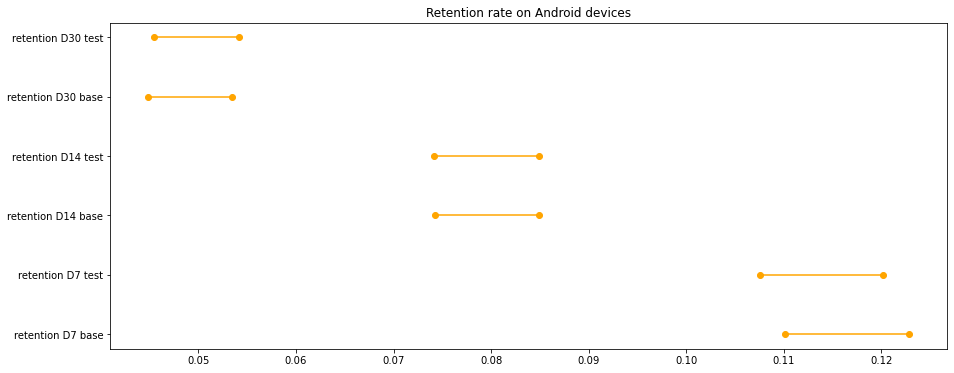

In [458]:
plt.rcParams["figure.figsize"] = (15,6)

for lower, upper, y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-', color='orange')
     
plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Retention rate on Android devices')

### undo_ios

In [312]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

sql = '''
SELECT distinct event_date, timestamp_micros(event_timestamp) as event_timestamp, event_name, user_id,  app_info.version,
    CASE userProperty.value.string_value WHEN "0" THEN "Baseline" WHEN "1" THEN "Variant A"
    END AS experimentVariant
FROM `lwapps-coloring.stg_analytics.firebase_events_event_date`,
    UNNEST(user_properties) AS userProperty,
    UNNEST(event_params) AS  eventParam
where userProperty.key = "firebase_exp_8" 
and event_date between '2021-02-22' AND '2021-03-29'
and lower(platform) = 'ios'
group by event_date, event_timestamp, event_name, user_id,  app_info.version, userProperty.value.string_value 
'''
# undo_ios = client.query(sql, project=project_id).to_dataframe()


In [313]:
undo_ios[undo_ios.event_name.str.contains("undo")].groupby(['experimentVariant', 'event_name']).event_timestamp.count()

experimentVariant  event_name            
Baseline           core_floating_undo_tap     5421
                   core_undo_tap             11520
Variant A          core_undo_tap                81
Name: event_timestamp, dtype: int64

In [314]:
returned_users = undo_ios[~undo_ios.user_id.isna()][['event_date', 'user_id', 'experimentVariant']].drop_duplicates()
returned_users.user_id = returned_users.user_id.astype(float)

tb = returned_users.groupby('user_id').experimentVariant.nunique().reset_index()
tb[tb.experimentVariant>1].user_id.tolist()

returned_users = returned_users[~returned_users.isin(tb[tb.experimentVariant>1].user_id.tolist())]

In [324]:
client = bigquery.Client.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
SELECT distinct event_date, customer_user_id as user_id, install_date, 
    date_diff(event_date, install_date, day) as cohort_day
FROM `goingtoclouds.appsflyer_happy_canvas.v_appsflyer_launch` 
WHERE event_date between "2021-02-20" and "2021-04-30"
and platform = 'ios' 
and date_diff(event_date, install_date, day)>=0
'''

launch_ios = client.query(sql, project=project_id).to_dataframe()
launch_ios = launch_ios[launch_ios.user_id.isin(returned_users.user_id.unique().tolist())]
launch_ios = launch_ios[["user_id", 'install_date', "event_date", "cohort_day"]]

In [325]:
returned_users_unique = returned_users[["user_id", "experimentVariant"]].drop_duplicates()

launch_ios = launch_ios.merge(returned_users_unique, how='left', on='user_id')

In [326]:
# leave installs after ab test start
launch_ios = launch_ios[(launch_ios.install_date >= dt.date(2021,2,22)) & 
                               (launch_ios.install_date<=dt.date(2021,3,29))]
launch_ios_retention = launch_ios[launch_ios.cohort_day.isin([0,7,14,30])]
launch_ios_retention

user_id install_date  event_date  cohort_day experimentVariant
19     818656.0   2021-03-26  2021-04-09          14          Baseline
36     780242.0   2021-03-10  2021-04-09          30         Variant A
48     818521.0   2021-03-26  2021-04-09          14          Baseline
59     734930.0   2021-02-22  2021-02-22           0          Baseline
60     736011.0   2021-02-22  2021-02-22           0         Variant A
...         ...          ...         ...         ...               ...
63634  638568.0   2021-03-01  2021-03-01           0          Baseline
63635  753486.0   2021-03-01  2021-03-01           0         Variant A
63640  753115.0   2021-03-01  2021-03-01           0          Baseline
63642  175279.0   2021-03-01  2021-03-01           0         Variant A
63645  753450.0   2021-03-01  2021-03-01           0         Variant A

[12819 rows x 5 columns]

In [327]:
ret_ios_agg = launch_ios_retention.groupby(['experimentVariant', 'cohort_day']).user_id.nunique().reset_index()
ret_ios_agg = pd.pivot_table(ret_ios_agg, index='experimentVariant', columns='cohort_day', values='user_id').reset_index()

ret_ios_agg['days_7'] = ret_ios_agg[7]/ret_ios_agg[0]
ret_ios_agg['days_14'] = ret_ios_agg[14]/ret_ios_agg[0]
ret_ios_agg['days_30'] = ret_ios_agg[30]/ret_ios_agg[0]

In [328]:
ret_ios_agg

cohort_day experimentVariant     0    7   14   30    days_7   days_14  \
0                   Baseline  4588  778  561  406  0.169573  0.122276   
1                  Variant A  4589  687  550  356  0.149706  0.119852   

cohort_day   days_30  
0           0.088492  
1           0.077577

In [358]:
launch_ios_retention

user_id install_date  event_date  cohort_day experimentVariant
19     818656.0   2021-03-26  2021-04-09          14          Baseline
36     780242.0   2021-03-10  2021-04-09          30         Variant A
48     818521.0   2021-03-26  2021-04-09          14          Baseline
59     734930.0   2021-02-22  2021-02-22           0          Baseline
60     736011.0   2021-02-22  2021-02-22           0         Variant A
...         ...          ...         ...         ...               ...
63634  638568.0   2021-03-01  2021-03-01           0          Baseline
63635  753486.0   2021-03-01  2021-03-01           0         Variant A
63640  753115.0   2021-03-01  2021-03-01           0          Baseline
63642  175279.0   2021-03-01  2021-03-01           0         Variant A
63645  753450.0   2021-03-01  2021-03-01           0         Variant A

[12819 rows x 5 columns]

In [382]:
day_0_base = launch_ios_retention[(launch_ios_retention.experimentVariant=='Baseline') & 
                                      (launch_ios_retention.cohort_day==0)][['user_id']].drop_duplicates()
day_0_base['appeared'] = 0

day_0_a = launch_ios_retention[(launch_ios_retention.experimentVariant=='Variant A') &
                                  (launch_ios_retention.cohort_day==0)][['user_id']].drop_duplicates()
day_0_a['appeared'] = 0

# day 7 ----------------------------------------------
day_7_base = launch_ios_retention[(launch_ios_retention.experimentVariant=='Baseline') & 
                                      (launch_ios_retention.cohort_day==7)][['user_id']].drop_duplicates()
day_7_base['appeared'] = 1
day_7_base = pd.concat([day_7_base, 
                        day_0_base[~day_0_base.user_id.isin(day_7_base.user_id.tolist())]])

day_7_a = launch_ios_retention[(launch_ios_retention.experimentVariant=='Variant A') & 
                                      (launch_ios_retention.cohort_day==7)][['user_id']].drop_duplicates()
day_7_a['appeared'] = 1
day_7_a = pd.concat([day_7_a, day_0_a[~day_0_a.user_id.isin(day_7_a.user_id.tolist())]])


# day 14 ----------------------------------------------
day_14_base = launch_ios_retention[(launch_ios_retention.experimentVariant=='Baseline') & 
                                      (launch_ios_retention.cohort_day==14)][['user_id']].drop_duplicates()
day_14_base['appeared'] = 1
day_14_base = pd.concat([day_14_base, 
                        day_0_base[~day_0_base.user_id.isin(day_14_base.user_id.tolist())]])

day_14_a = launch_ios_retention[(launch_ios_retention.experimentVariant=='Variant A') & 
                                      (launch_ios_retention.cohort_day==14)][['user_id']].drop_duplicates()
day_14_a['appeared'] = 1
day_14_a = pd.concat([day_14_a, day_0_a[~day_0_a.user_id.isin(day_14_a.user_id.tolist())]])


# day 30 ----------------------------------------------
day_30_base = launch_ios_retention[(launch_ios_retention.experimentVariant=='Baseline') & 
                                      (launch_ios_retention.cohort_day==30)][['user_id']].drop_duplicates()
day_30_base['appeared'] = 1
day_30_base = pd.concat([day_30_base, 
                        day_0_base[~day_0_base.user_id.isin(day_30_base.user_id.tolist())]])

day_30_a = launch_ios_retention[(launch_ios_retention.experimentVariant=='Variant A') & 
                                      (launch_ios_retention.cohort_day==30)][['user_id']].drop_duplicates()
day_30_a['appeared'] = 1
day_30_a = pd.concat([day_30_a, day_0_a[~day_0_a.user_id.isin(day_30_a.user_id.tolist())]])

In [437]:
conf_int_7_ios_base = proportion_confint(sum(day_7_base.appeared), len(day_7_base.appeared), method = 'wilson')
conf_int_7_ios_a = proportion_confint(sum(day_7_a.appeared), len(day_7_a.appeared), method = 'wilson')

conf_int_14_ios_base = proportion_confint(sum(day_14_base.appeared), len(day_14_base.appeared), method = 'wilson')
conf_int_14_ios_a = proportion_confint(sum(day_14_a.appeared), len(day_14_a.appeared), method = 'wilson')

conf_int_30_ios_base = proportion_confint(sum(day_30_base.appeared), len(day_30_base.appeared), method = 'wilson')
conf_int_30_ios_a = proportion_confint(sum(day_30_a.appeared), len(day_30_a.appeared), method = 'wilson')

In [439]:
print("confidence interval retention 7 days: [%f, %f]" %  proportions_confint_diff_ind(day_7_base.appeared, day_7_a.appeared))
print("confidence interval retention 14 days: [%f, %f]" %  proportions_confint_diff_ind(day_14_base.appeared, day_14_a.appeared))
print("confidence interval retention 30 days: [%f, %f]" %  proportions_confint_diff_ind(day_30_base.appeared, day_30_a.appeared))


confidence interval retention 7 days: [0.004830, 0.034709]
confidence interval retention 14 days: [-0.010797, 0.015844]
confidence interval retention 30 days: [-0.000410, 0.022130]


In [445]:
data_dict = {}
data_dict['category'] = ['retention D7 base', 'retention D7 test', 'retention D14 base', 'retention D14 test',
                        'retention D30 base', 'retention D30 test']
data_dict['lower'] = [conf_int_7_ios_base[0], conf_int_7_ios_a[0], conf_int_14_ios_base[0], conf_int_14_ios_a[0],
                     conf_int_30_ios_base[0], conf_int_30_ios_a[0]]
data_dict['upper'] = [conf_int_7_ios_base[1], conf_int_7_ios_a[1], conf_int_14_ios_base[1], conf_int_14_ios_a[1],
                     conf_int_30_ios_base[1], conf_int_30_ios_a[1]]
dataset = pd.DataFrame(data_dict)

dataset

category     lower     upper
0   retention D7 base  0.158471  0.180122
1   retention D7 test  0.139249  0.159837
2  retention D14 base  0.112913  0.131844
3  retention D14 test  0.110481  0.129232
4  retention D30 base  0.080456  0.096869
5  retention D30 test  0.070078  0.085545

Text(0.5, 1.0, 'Retention rate on IOS devices')

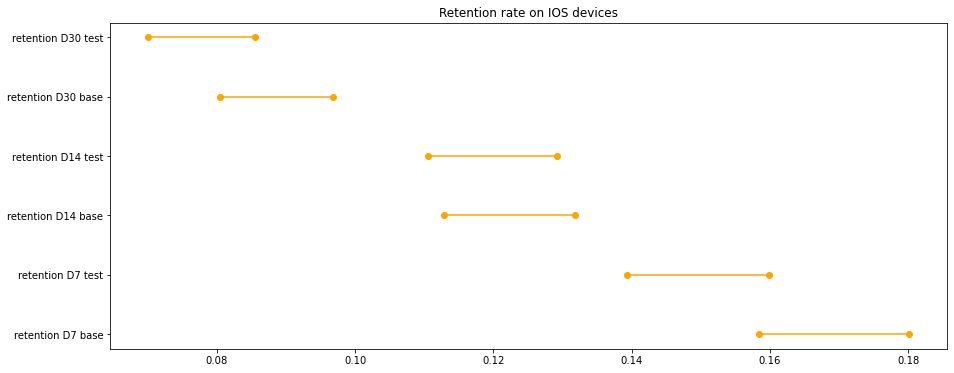

In [455]:
plt.rcParams["figure.figsize"] = (15,6)

for lower, upper, y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-', color='orange')
     
plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Retention rate on IOS devices')

In [433]:
ret_ios_agg

cohort_day experimentVariant     0    7   14   30    days_7   days_14  \
0                   Baseline  4588  778  561  406  0.169573  0.122276   
1                  Variant A  4589  687  550  356  0.149706  0.119852   

cohort_day   days_30  
0           0.088492  
1           0.077577